In [1]:
import inspect, os, sys

import re
import json
import statistics
import argparse
import itertools
from glob import glob
from pathlib import Path
from dataclasses import dataclass
from typing import  Iterable, Any


def cd_if_exists(dir: Path | str) -> bool:
    if isinstance(dir, str):
        dir = Path(dir)
    if dir.exists() and dir.is_dir():
        os.chdir(dir)
        return True
    else:
        return False

# Normally start VSCode (or whatever you use to run this notebook interactively) from the root, so
# we have to `cd` into the parent dir of this file, to access utils functions.
cd_if_exists('./scripts')

# These are util functions
from ldj import ldj
from utils import *

import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import PathPatch
from matplotlib.path import get_path_collection_extents
import seaborn as sns

from rich import print, pretty
from tabulate import tabulate
import pretty_errors
from catppuccin import PALETTE
from IPython.display import display, HTML

pretty.install()
print(f"{os.getcwd()=}")

EXPERIMENT_DIR = Path("../experiments/structured-junction-twoway")
assert EXPERIMENT_DIR.is_dir() and EXPERIMENT_DIR.exists()

flavor = PALETTE.latte.colors
# data = dict()


sys.executable = '/nix/store/7hnr99nxrd2aw6lghybqdmkckq60j6l9-python3-3.11.9/bin/python3.11'

sys.version = '3.11.9 (main, Apr  2 2024, 08:25:04) [GCC 13.2.0]'

os.getcwd()='/home/kpbaks/university/semesters/10/master-thesis/gbp-rs/scripts'

In [17]:
@dataclass(frozen=True)
class Statistics:
    mean: float
    median: float
    stdev: float
    min: float
    max: float


    def display(self) -> None:
        data = [
            ["Mean", self.mean],
            ["Median", self.median],
            ["Standard Deviation", self.stdev],
            ["Min", self.min],
            ["Max", self.max]
        ]
        html_table = tabulate(data, headers=["Statistic", "Value"], tablefmt="html")
        centered_html_table = f"""
        <div style="display: flex; justify-content: center;">
            {html_table}
        </div>
        """
        display(HTML(html_table))
        # display(HTML(centered_html_table))


def compute_stats(data: list[float]) -> Statistics:
    return Statistics(
        mean=np.mean(data),
        median=np.median(data),
        stdev=np.std(data),
        min=np.min(data),
        max=np.max(data),
    )


In [3]:
@dataclass(frozen=True)
class PerpendicularPositionErrorResult:
    errors: list[float]
    rmses: list[float]


def perpendicular_position_error(exported_data: dict) -> PerpendicularPositionErrorResult:
    errors: list[float] = []
    rmses: list[float] = []

    for robot_id, robot_data in exported_data['robots'].items():
        color: str = robot_data['color']
        positions = np.array([p for p in robot_data['positions']])
        mission = robot_data['mission']
        waypoints = []
        for route in mission['routes']:
            waypoints.append(route['waypoints'][0])
            for wp in route['waypoints'][1:]:
                waypoints.append(wp)

        waypoints = np.array(waypoints)
        waypoints = np.squeeze(waypoints)

        lines: list[LinePoints] = [LinePoints(start=start, end=end) for start, end in sliding_window(waypoints, 2)]
        closest_projections = [closest_projection_onto_line_segments(p, lines) for p in positions]

        error: float = np.sum(np.linalg.norm(positions - closest_projections, axis=1))
        rmse: float = np.sqrt(error / len(positions))

        errors.append(error)
        rmses.append(rmse)

    return PerpendicularPositionErrorResult(errors=errors, rmses=rmses)


In [4]:
@dataclass(frozen=True)
class CollisionsResult:
    interrobot: int
    environment: int

def collisions(exported_data: dict) -> CollisionsResult:
    interrobot: int = len(exported_data['collisions']['robots'])
    environment: int = len(exported_data['collisions']['environment'])
    return CollisionsResult(interrobot=interrobot, environment=environment)


In [5]:
@dataclass(frozen=True)
class Metric:
    ppe: PerpendicularPositionErrorResult
    collisions: CollisionsResult


In [6]:
def flatten(lst: Iterable) -> list:
    return list(itertools.chain.from_iterable(lst))


In [7]:
@dataclass
class Results:
    with_tracking: dict[str, Metric]
    without_tracking: dict[str, Metric]

results = Results(dict(), dict())

RE = re.compile(r"tracking-(on|off)-failure-(\d\.\d)\.json")

for f in EXPERIMENT_DIR.iterdir():
    captures = RE.match(f.name)
    assert captures is not None
    tracking = captures.group(1)
    failure_prob = captures.group(2)

    with open(f) as f:
        data = json.load(f)

    ppe = perpendicular_position_error(data)
    metric = Metric(ppe=ppe, collisions=collisions(data))

    match tracking:
        case "on":
            results.with_tracking[failure_prob] = metric
        case "off":
            results.without_tracking[failure_prob] = metric
        case _:
            assert False


# print(f"{results=}")


## Perpendicular Position Error

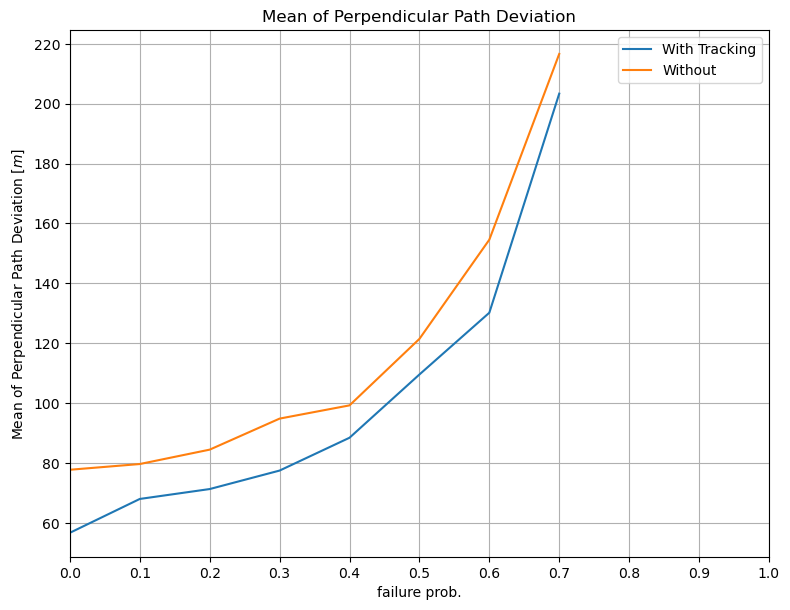

In [61]:
fig, ax = plt.subplots(1, figsize=(8, 6))

with_tracking_data = {k: compute_stats(v.ppe.errors).mean for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: compute_stats(v.ppe.errors).mean for k, v in sorted(results.without_tracking.items())}

plt.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="With Tracking"
)

plt.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without"
)

ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))  # Setting xtick resolution to 0.1
ax.set_xlabel("failure prob.")
ax.set_ylabel("Mean of Perpendicular Path Deviation $[m]$")
plt.tight_layout()
ax.set_title("Mean of Perpendicular Path Deviation")
ax.legend()
plt.savefig("perpendicular-path-deviation-structured-junction-twoway.svg", pad_inches=1.0)
plt.show()

## Collisions

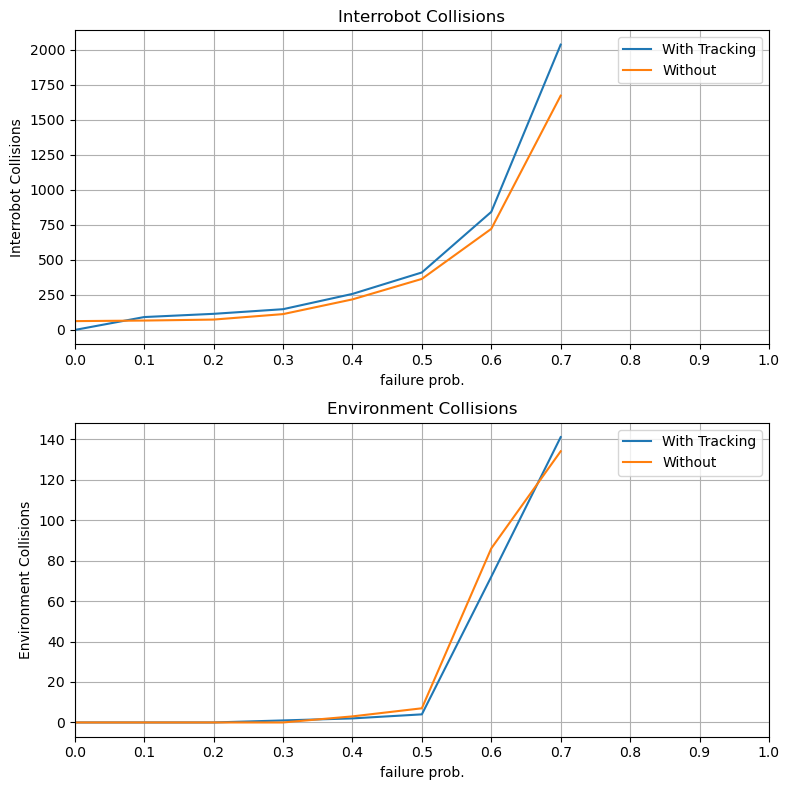

In [63]:
fig, axs = plt.subplots(2, figsize=(8,8))

ax = axs[0]

with_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.interrobot for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="With Tracking"
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without"
)

ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))  # Setting xtick resolution to 0.1
ax.set_xlabel("failure prob.")
ax.set_ylabel("Interrobot Collisions")
plt.tight_layout()
ax.set_title("Interrobot Collisions")
ax.legend()

ax = axs[1]

with_tracking_data = {k: v.collisions.environment for k, v in sorted(results.with_tracking.items())}
without_tracking_data = {k: v.collisions.environment for k, v in sorted(results.without_tracking.items())}

ax.plot(
    [float(k) for k in with_tracking_data.keys()],
    with_tracking_data.values(),
    label="With Tracking"
)

ax.plot(
    [float(k) for k in without_tracking_data.keys()],
    without_tracking_data.values(),
    label="Without"
)

ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xlabel("failure prob.")
ax.set_xticks(np.arange(0, 1.1, 0.1))  # Setting xtick resolution to 0.1
ax.set_ylabel("Environment Collisions")
ax.set_title("Environment Collisions")
ax.legend()



plt.tight_layout()
plt.savefig("collisions-structured-junction-twoway.svg")
plt.show()


In [11]:
{k: v.collisions for k, v in sorted(results.with_tracking.items())}


{
    '0.0': CollisionsResult(interrobot=0, environment=0),
    '0.1': CollisionsResult(interrobot=92, environment=0),
    '0.2': CollisionsResult(interrobot=115, environment=0),
    '0.3': CollisionsResult(interrobot=148, environment=1),
    '0.4': CollisionsResult(interrobot=257, environment=2),
    '0.5': CollisionsResult(interrobot=410, environment=4),
    '0.6': CollisionsResult(interrobot=842, environment=72),
    '0.7': CollisionsResult(interrobot=2035, environment=141)
}

# Without Tracking

## Perpendicular Position Error

In [46]:
# for failure_prob, metric in sorted(results.with_tracking.items()):
#     print(f"{failure_prob=}")
#     compute_stats(metric.ppe.errors).display()

for failure_prob, metric in sorted(results.with_tracking.items()):
    print(f"{failure_prob=}")
    compute_stats(metric.ppe.errors).display()

failure_prob='0.0'

Statistic,Value
Mean,56.6555
Median,44.22
Standard Deviation,42.7886
Min,7.81347e-13
Max,149.517


failure_prob='0.1'

Statistic,Value
Mean,67.9578
Median,50.9305
Standard Deviation,58.62
Min,7.88453e-13
Max,845.304


failure_prob='0.2'

Statistic,Value
Mean,71.2628
Median,52.8193
Standard Deviation,54.8485
Min,7.81347e-13
Max,537.392


failure_prob='0.3'

Statistic,Value
Mean,77.4372
Median,60.5334
Standard Deviation,52.3455
Min,0.578517
Max,416.138


failure_prob='0.4'

Statistic,Value
Mean,88.4001
Median,70.0348
Standard Deviation,66.2197
Min,0.339383
Max,604.721


failure_prob='0.5'

Statistic,Value
Mean,109.526
Median,82.7958
Standard Deviation,215.398
Min,0.223903
Max,7094.1


failure_prob='0.6'

Statistic,Value
Mean,130.156
Median,106.854
Standard Deviation,87.7025
Min,0.499764
Max,663.997


failure_prob='0.7'

Statistic,Value
Mean,203.333
Median,165.355
Standard Deviation,155.307
Min,4.12985
Max,1819.07


## Collisions

In [14]:
{k: v.collisions for k, v in sorted(results.without_tracking.items())}


{
    '0.0': CollisionsResult(interrobot=63, environment=0),
    '0.1': CollisionsResult(interrobot=67, environment=0),
    '0.2': CollisionsResult(interrobot=74, environment=0),
    '0.3': CollisionsResult(interrobot=113, environment=0),
    '0.4': CollisionsResult(interrobot=218, environment=3),
    '0.5': CollisionsResult(interrobot=364, environment=7),
    '0.6': CollisionsResult(interrobot=721, environment=86),
    '0.7': CollisionsResult(interrobot=1671, environment=134)
}

In [60]:
os.getcwd()


'/home/kpbaks/university/semesters/10/master-thesis/gbp-rs/scripts'